In [1]:
#Setup

# Install Packages
import sys
!{sys.executable} -m pip install numpy --quiet
!{sys.executable} -m pip install matplotlib --quiet
!{sys.executable} -m pip install seaborn --quiet
!{sys.executable} -m pip install sklearn --quiet
!{sys.executable} -m pip install torch --quiet

from sklearn import preprocessing
import os, requests
from matplotlib import rcParams 
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import math
from sklearn.linear_model import LinearRegression
import torch

# Data Retrieval

fname = 'joystick_track.npz'
url = "https://osf.io/6jncm/download"

print('Is cuda?', torch.cuda.is_available())

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)
# Import matplotlib and set styling
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

colourmap_diverge = sns.diverging_palette(321, 172, s=100, n=100, center = "light", as_cmap=True)
colourmap = sns.color_palette("rocket", as_cmap=True)
colourmap = sns.light_palette("#30887c", as_cmap=True)
colourmap_diverge.set_bad("black", alpha=0)
colourmap.set_bad("black", alpha=0)

# Data Loading
alldat = np.load(fname, allow_pickle=True)['dat']

# Select just one of the recordings here. This is subject 1, block 1.
dat = alldat[0, 3]

You should consider upgrading via the 'C:\Users\richa\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\richa\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\richa\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\richa\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\richa\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


Is cuda? False


In [2]:
# Define normalisation of voltage channels

Vmax =  max((max(x) for x in dat['V']))
Vmin = min((min(x) for x in dat['V']))
xmax = max(dat['cursorX'])
xmin = min(dat['cursorX'])
ymax = max(dat['cursorY'])
ymin = min(dat['cursorY'])

def Vnormalise(_V):
    _V_norm = (_V - Vmin)/(Vmax - Vmin)
    return _V_norm

def normalise(_V):
    _V_norm = (_V - min(_V))/(max(_V) - min(_V))
    return _V_norm

def Xnormalise(_x):
    _x_norm = (_x - xmin)/(xmax - xmin)
    return _x_norm
    
def Xdenormalise(_x):
    _x_denorm = _x*(xmax - xmin) + xmin
    return _x_denorm

def Ynormalise(_y):
    _y_norm = (_y - ymin)/(ymax - ymin)
    return _y_norm
    
def Ydenormalise(_y):
    _y_denorm = _y*(ymax - ymin) + ymin
    return _y_denorm

In [3]:
# Load patient 2
dat = alldat[0, 2]

V = dat['V']
nt, nchan = V.shape
print(nt, nchan)

cx = Xnormalise(dat['cursorX'].flatten())
cy = Ynormalise(dat['cursorY'].flatten())

134360 64


In [4]:
# split into 80:20 train test split
nt, nchan = V.shape

boundary = math.ceil(nt*0.8)

V_train = V[:boundary, :]
V_test = V[boundary:, :]

cx_train = cx[:boundary]
cx_test = cx[boundary:]
cy_train = cy[:boundary]
cy_test = cy[boundary:]

In [5]:
print("prenorm limits:")
print('X:', xmin, xmax)
print('Y:', ymin, ymax)
print("norm limits:")
print('X:', min(cx_train), max(cx_train))
print('Y:', min(cy_train), max(cy_train))



prenorm limits:
X: [0] [32767]
Y: [0] [32767]
norm limits:
X: 0.0 1.0
Y: 0.0 1.0


In [6]:
#Define matrix construction
import numpy as np
from sklearn.linear_model import LinearRegression

def construct_matrices (_V, _cx, _cy, _h, _l, _norm):
    # Construct test matrices
    nt, nchan = _V.shape
    
    # Normalise, if desired
    if _norm == True:
        for c in range(nchan):
            _V[:,c] = normalise(_V[:,c])

    # Generate feature indices
    i0 = _h*_l
    iN = nt
    test_step = 1
    indices = range(i0, iN, test_step)

    # Generate 
    no_obs = len(indices)
    no_vars_rgand = 2    #Number of regressand variables (x and y)
    no_vars_rgor = nchan * (_h+1)

    regressand = np.zeros((no_obs, no_vars_rgand))
    regressor = np.zeros((no_obs, no_vars_rgor))
    
    for j, ind in enumerate(indices):
        regressand[j, 0] = _cx[ind]
        regressand[j, 1] = _cy[ind]
        for i, chan in enumerate(range(nchan)):
            for h in range(_h+1):
                regressor[j, (_h+1)*i + h] = _V[ind - h*_l, i]
                
    regressor = torch.from_numpy(regressor)
    regressor = regressor.float()
    regressand = torch.from_numpy(regressand)
    regressand = regressand.float()

    return regressor, regressand

#Define matrix construction
import numpy as np
from sklearn.linear_model import LinearRegression

corr_chan = sorted([5, 23, 17, 1, 25])
#Generate the independent and dependent variable matrices for correlated channels
def construct_matrices_corr (_V, _cx, _cy, _h, _l, _norm):
    _V_corr = _V[:,corr_chan]
    # Construct test matrices
    nt, nchan = _V_corr.shape
    
    # Normalise, if desired
    if _norm == True:
        for c in range(nchan):
            _V_corr[:,c] = normalise(_V_corr[:,c])

    # Generate feature indices
    i0 = _h*_l
    iN = nt
    test_step = 1
    indices = range(i0, iN, test_step)

    # Generate 
    no_obs = len(indices)
    no_vars_rgand = 2    #Number of regressand variables (x and y)
    no_vars_rgor = nchan * (_h+1)

    regressand = np.zeros((no_obs, no_vars_rgand))
    regressor = np.zeros((no_obs, no_vars_rgor))
    
    for j, ind in enumerate(indices):
        regressand[j, 0] = _cx[ind]
        regressand[j, 1] = _cy[ind]
        for i, chan in enumerate(range(nchan)):
            for h in range(_h+1):
                regressor[j, (_h+1)*i + h] = _V_corr[ind - h*_l, i]
                
    regressor = torch.from_numpy(regressor)
    regressor = regressor.float()
    regressand = torch.from_numpy(regressand)
    regressand = regressand.float()

    return regressor, regressand

In [7]:
def MLP(_V_train, _cx_train, _cy_train, _V_test, _cx_test, _cy_test, _h, _l):
    _regressor_train, _regressand_train = construct_matrices(_V_train, _cx_train, _cy_train, _h, _l, normalise=True)
    _regressor_test, _regressand_test = construct_matrices(_V_test, _cx_test, _cy_test, _h, _l, normalise=True)


    _model = LR_fit(_regressor_train, _regressand_train)
    _prediction = LR_predict(_regressor_test, _model)

    return _regressand_test, _prediction

def MLP_fit(regor, regand):
    reg = LinearRegression()
    reg.fit(regor, regand)
    #print('shape:', reg.coef_.shape)
    #print('score:', reg.score(regor, regand))
    return reg

def LR_predict(regor, _model):
    predict = _model.predict(regor[:,:])
    return predict

        

In [8]:
class Feedforward(torch.nn.Module):
        def __init__(self, input_size, hidden_size):
            super(Feedforward, self).__init__()
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.relu = torch.nn.ReLU()
            self.fc2 = torch.nn.Linear(self.hidden_size, 1)
            self.sigmoid = torch.nn.Sigmoid()
        def forward(self, x):
            hidden = self.fc1(x)
            relu = self.relu(hidden)
            output = self.fc2(relu)
            output = self.sigmoid(output)
            return output

In [9]:
h = 10
l = 400
x_train, y_train = construct_matrices(V_train, cx_train, cy_train, h, l, _norm=True)
x_test, y_test = construct_matrices(V_test, cx_test, cy_test, h, l, _norm=True)

yX_train = y_train[:,0]
yY_train = y_train[:,1]
yX_test = y_test[:,0]
yY_test = y_test[:,1]

In [10]:
modelX = Feedforward(x_train.shape[1], 20)
modelY = Feedforward(x_train.shape[1], 20)

loss = torch.nn.L1Loss()
optimizerX = torch.optim.SGD(modelX.parameters(), lr = 0.1)
optimizerY = torch.optim.SGD(modelY.parameters(), lr = 0.1)


In [11]:
modelX.eval()
yX_pred_init = modelX(x_test)
yY_pred_init = modelY(x_test)
before_trainX = loss(yX_pred_init.squeeze(), yX_test.squeeze())
before_trainY = loss(yY_pred_init.squeeze(), yY_test.squeeze())

print('Test loss before training, X:' , before_trainX.item(), 'Y:', before_trainY.item())

Test loss before training, X: 0.34879812598228455 Y: 0.3285466134548187


Epoch 0: train lossX: 0.2949569523334503 train lossY: 0.3081011176109314
Epoch 50: train lossX: 0.26204851269721985 train lossY: 0.2308816760778427
Epoch 100: train lossX: 0.24119535088539124 train lossY: 0.21799708902835846
Epoch 150: train lossX: 0.20876267552375793 train lossY: 0.19538255035877228
Epoch 200: train lossX: 0.22443415224552155 train lossY: 0.19625726342201233
Epoch 250: train lossX: 0.21443897485733032 train lossY: 0.19339118897914886
Epoch 300: train lossX: 0.1983976662158966 train lossY: 0.20484496653079987
Epoch 350: train lossX: 0.19166290760040283 train lossY: 0.14722585678100586
Epoch 400: train lossX: 0.18385744094848633 train lossY: 0.19757257401943207
Epoch 450: train lossX: 0.17615897953510284 train lossY: 0.1628243625164032
Epoch 500: train lossX: 0.17593802511692047 train lossY: 0.1666606068611145
Epoch 550: train lossX: 0.17364022135734558 train lossY: 0.15872615575790405
Epoch 600: train lossX: 0.17169156670570374 train lossY: 0.15278495848178864
Epoch 65

<function matplotlib.pyplot.legend(*args, **kwargs)>

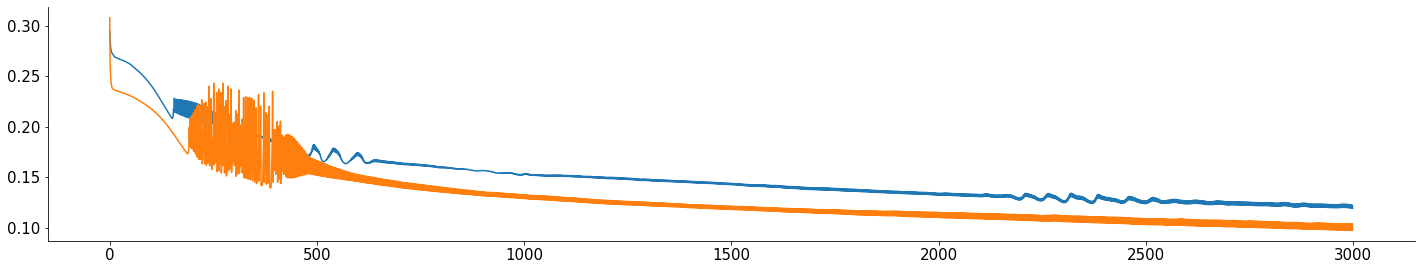

In [12]:
modelX.train()
modelY.train()
epoch = 3000
L1Xs = []
L1Ys = []
for epoch in range(epoch):
    optimizerX.zero_grad()
    optimizerY.zero_grad()
    # Forward pass
    yX_pred = modelX(x_train)
    yY_pred = modelY(x_train)
    # Compute Loss
    L1X = loss(yX_pred.squeeze(), yX_train)
    L1Y = loss(yY_pred.squeeze(), yY_train)

    #L1 regularization (as some channels are known to not be relevant)
    reg_lambda = 0.001
    #reg_normX = sum(p.abs().sum()
    #              for p in modelX.parameters())
    #L1X = L1X + reg_lambda * reg_normX
    #reg_normY = sum(p.abs().sum()
    #              for p in modelY.parameters())
    #L1Y = L1Y + reg_lambda * reg_normY
    
    L1Xs.append(L1X.item())
    L1Ys.append(L1Y.item())
    
    # Backward pass
    L1X.backward()
    optimizerX.step()
    L1Y.backward()
    optimizerY.step()
    
    if epoch%50 == 0:
        print('Epoch {}: train lossX: {}'.format(epoch, L1X.item()), 'train lossY: {}'.format(L1Y.item()))
        
plt.plot(L1Xs, label='X loss')
plt.plot(L1Ys, label='Y loss')
plt.legend



In [13]:
modelX.eval()
yX_pred = modelX(x_test)
modelY.eval()
yY_pred = modelY(x_test)


after_trainX = loss(yX_pred.squeeze(), yX_test) 
after_trainY = loss(yY_pred.squeeze(), yY_test) 

print('Test loss after Training:')
print('X:' , after_trainX.item())
print('Y:' , after_trainY.item())

Test loss after Training:
X: 0.13017460703849792
Y: 0.18242336809635162


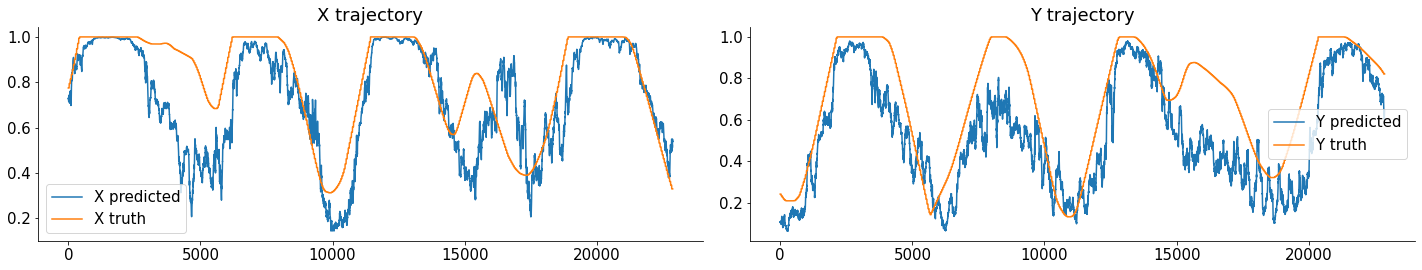

In [14]:
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(yX_pred.tolist(), label="X predicted")
plt.plot(yX_test, label="X truth")
plt.title('X trajectory')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(yY_pred.tolist(), label="Y predicted")
plt.plot(yY_test, label="Y truth")
plt.title('Y trajectory')
plt.legend()

Test loss before training, X: 0.3474944233894348 Y: 0.2730602025985718
Epoch 0: train lossX: 0.2941632866859436 train lossY: 0.25724488496780396
Epoch 50: train lossX: 0.2658741772174835 train lossY: 0.2349657416343689
Epoch 100: train lossX: 0.2610057592391968 train lossY: 0.23211269080638885
Epoch 150: train lossX: 0.254657506942749 train lossY: 0.22875480353832245
Epoch 200: train lossX: 0.24586233496665955 train lossY: 0.2246161699295044
Epoch 250: train lossX: 0.2342449277639389 train lossY: 0.21935200691223145
Epoch 300: train lossX: 0.22062146663665771 train lossY: 0.21265754103660583
Epoch 350: train lossX: 0.20677435398101807 train lossY: 0.20438718795776367
Epoch 400: train lossX: 0.19480100274085999 train lossY: 0.1948317289352417
Epoch 450: train lossX: 0.18483415246009827 train lossY: 0.1859663426876068
Epoch 500: train lossX: 0.177524134516716 train lossY: 0.17802555859088898
Epoch 550: train lossX: 0.17199039459228516 train lossY: 0.17088967561721802
Epoch 600: train los

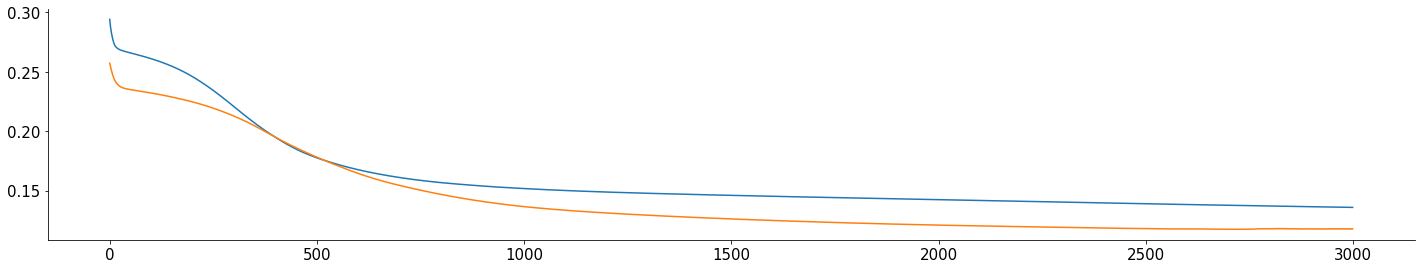

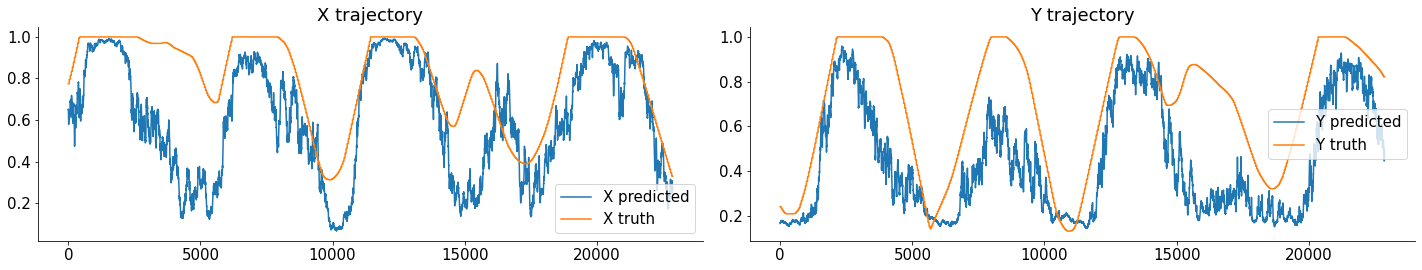

In [16]:
# Repeat the above, using only the correlated channels

h = 10
l = 400
x_train, y_train = construct_matrices_corr(V_train, cx_train, cy_train, h, l, _norm=True)
x_test, y_test = construct_matrices_corr(V_test, cx_test, cy_test, h, l, _norm=True)

yX_train = y_train[:,0]
yY_train = y_train[:,1]
yX_test = y_test[:,0]
yY_test = y_test[:,1]



modelX = Feedforward(x_train.shape[1], 20)
modelY = Feedforward(x_train.shape[1], 20)

loss = torch.nn.L1Loss()
optimizerX = torch.optim.SGD(modelX.parameters(), lr = 0.1)
optimizerY = torch.optim.SGD(modelY.parameters(), lr = 0.1)

modelX.eval()
yX_pred_init = modelX(x_test)
yY_pred_init = modelY(x_test)
before_trainX = loss(yX_pred_init.squeeze(), yX_test.squeeze())
before_trainY = loss(yY_pred_init.squeeze(), yY_test.squeeze())

print('Test loss before training, X:' , before_trainX.item(), 'Y:', before_trainY.item())

modelX.train()
modelY.train()
epoch = 3000
L1Xs = []
L1Ys = []
for epoch in range(epoch):
    optimizerX.zero_grad()
    optimizerY.zero_grad()
    # Forward pass
    yX_pred = modelX(x_train)
    yY_pred = modelY(x_train)
    # Compute Loss
    L1X = loss(yX_pred.squeeze(), yX_train)
    L1Y = loss(yY_pred.squeeze(), yY_train)

    #L1 regularization (as some channels are known to not be relevant)
    reg_lambda = 0.001
    #reg_normX = sum(p.abs().sum()
    #              for p in modelX.parameters())
    #L1X = L1X + reg_lambda * reg_normX
    #reg_normY = sum(p.abs().sum()
    #              for p in modelY.parameters())
    #L1Y = L1Y + reg_lambda * reg_normY
    
    L1Xs.append(L1X.item())
    L1Ys.append(L1Y.item())
    
    # Backward pass
    L1X.backward()
    optimizerX.step()
    L1Y.backward()
    optimizerY.step()
    
    if epoch%50 == 0:
        print('Epoch {}: train lossX: {}'.format(epoch, L1X.item()), 'train lossY: {}'.format(L1Y.item()))
        
plt.plot(L1Xs, label='X loss')
plt.plot(L1Ys, label='Y loss')
plt.legend



#Evaluate model
modelX.eval()
yX_pred = modelX(x_test)
modelY.eval()
yY_pred = modelY(x_test)


after_trainX = loss(yX_pred.squeeze(), yX_test) 
after_trainY = loss(yY_pred.squeeze(), yY_test) 

print('Test loss after Training:')
print('X:' , after_trainX.item())
print('Y:' , after_trainY.item())


#Plot prediction
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(yX_pred.tolist(), label="X predicted")
plt.plot(yX_test, label="X truth")
plt.title('X trajectory')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(yY_pred.tolist(), label="Y predicted")
plt.plot(yY_test, label="Y truth")
plt.title('Y trajectory')
plt.legend()

Test loss before training, X: 0.2941369116306305 Y: 0.2912438213825226
Epoch 0: train lossX: 0.27630293369293213 train lossY: 0.27371472120285034
Epoch 50: train lossX: 0.2583484649658203 train lossY: 0.22665010392665863
Epoch 100: train lossX: 0.23313936591148376 train lossY: 0.20917196571826935
Epoch 150: train lossX: 0.2155143767595291 train lossY: 0.18189716339111328
Epoch 200: train lossX: 0.20855861902236938 train lossY: 0.18779003620147705
Epoch 250: train lossX: 0.20098631083965302 train lossY: 0.17134347558021545
Epoch 300: train lossX: 0.19614540040493011 train lossY: 0.1518915891647339
Epoch 350: train lossX: 0.18898098170757294 train lossY: 0.14483925700187683
Epoch 400: train lossX: 0.1814582794904709 train lossY: 0.13879531621932983
Epoch 450: train lossX: 0.1774098128080368 train lossY: 0.13845589756965637
Epoch 500: train lossX: 0.17293645441532135 train lossY: 0.18077565729618073
Epoch 550: train lossX: 0.16901491582393646 train lossY: 0.14161190390586853
Epoch 600: tr

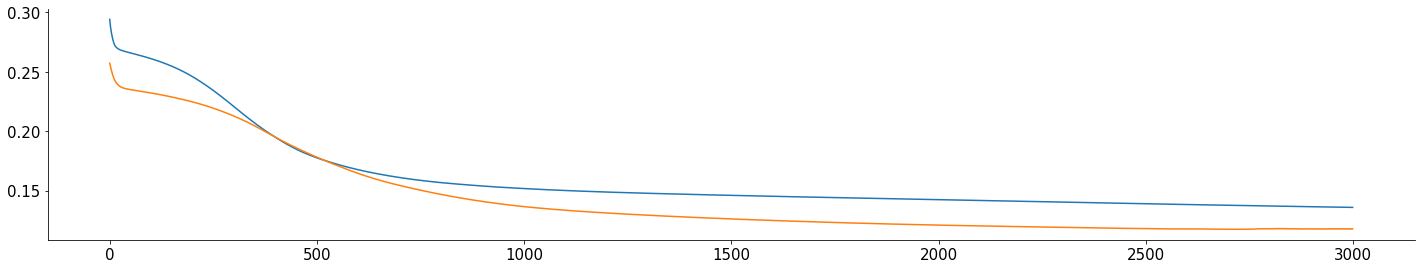

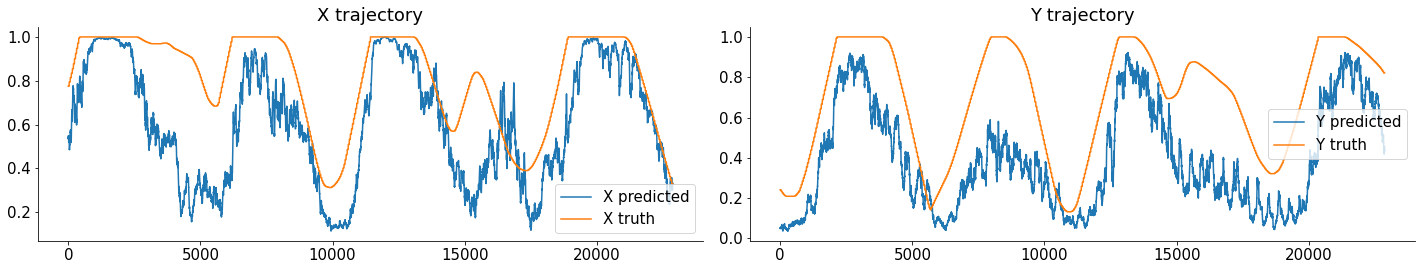

In [17]:
# Repeat the above, using a global loss function

h = 10
l = 400
x_train, y_train = construct_matrices(V_train, cx_train, cy_train, h, l, _norm=True)
x_test, y_test = construct_matrices(V_test, cx_test, cy_test, h, l, _norm=True)

yX_train = y_train[:,0]
yY_train = y_train[:,1]
yX_test = y_test[:,0]
yY_test = y_test[:,1]



modelX = Feedforward(x_train.shape[1], 20)
modelY = Feedforward(x_train.shape[1], 20)

loss = torch.nn.L1Loss()
optimizerX = torch.optim.SGD(modelX.parameters(), lr = 0.1)
optimizerY = torch.optim.SGD(modelY.parameters(), lr = 0.1)

modelX.eval()
yX_pred_init = modelX(x_test)
yY_pred_init = modelY(x_test)
before_trainX = loss(yX_pred_init.squeeze(), yX_test.squeeze())
before_trainY = loss(yY_pred_init.squeeze(), yY_test.squeeze())

print('Test loss before training, X:' , before_trainX.item(), 'Y:', before_trainY.item())

modelX.train()
modelY.train()
epoch = 3000
L1s = []
for epoch in range(epoch):
    optimizerX.zero_grad()
    optimizerY.zero_grad()
    # Forward pass
    yX_pred = modelX(x_train)
    yY_pred = modelY(x_train)
    # Compute Loss
    L1X = loss(yX_pred.squeeze(), yX_train)
    L1Y = loss(yY_pred.squeeze(), yY_train)

    #L1 regularization (as some channels are known to not be relevant)
    reg_lambda = 0.001
    #reg_normX = sum(p.abs().sum()
    #              for p in modelX.parameters())
    #L1X = L1X + reg_lambda * reg_normX
    #reg_normY = sum(p.abs().sum()
    #              for p in modelY.parameters())
    #L1Y = L1Y + reg_lambda * reg_normY
    
    L1 = L1X + L1Y
    
    L1s.append(L1)
    
    # Backward pass
    L1.backward()
    optimizerX.step()
    optimizerY.step()
    
    if epoch%50 == 0:
        print('Epoch {}: train lossX: {}'.format(epoch, L1X.item()), 'train lossY: {}'.format(L1Y.item()))
        
plt.plot(L1Xs, label='X loss')
plt.plot(L1Ys, label='Y loss')
plt.legend



#Evaluate model
modelX.eval()
yX_pred = modelX(x_test)
modelY.eval()
yY_pred = modelY(x_test)


after_trainX = loss(yX_pred.squeeze(), yX_test) 
after_trainY = loss(yY_pred.squeeze(), yY_test) 

print('Test loss after Training:')
print('X:' , after_trainX.item())
print('Y:' , after_trainY.item())


#Plot prediction
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(yX_pred.tolist(), label="X predicted")
plt.plot(yX_test, label="X truth")
plt.title('X trajectory')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(yY_pred.tolist(), label="Y predicted")
plt.plot(yY_test, label="Y truth")
plt.title('Y trajectory')
plt.legend()